![Header.jpeg](../assets/banner_linreg.png)

# Analisis dan Prediksi Konsumsi Energi pada Bangunan Menggunakan Algoritma *Ridge*, *Lasso* dan *Elastic Net Regression*

---

<h2>Daftar isi</h2>

- <a href=#bu>Business Understanding</a>
- <a href=#du>Data Understanding</a>
- <a href=#dp>Data Preparation</a>
- <a href=#ml>Modeling</a>
- <a href=#ev>Evaluation</a>
- <a href=#dy>Deployment</a>


<hr>


<h2 id='bu'>Business Understanding</h2>

Dataset "Energy Consumption" berguna untuk mengetahui pola penggunaan energi yang dibutuhkan oleh suatu bangunan berdasarkan karakteristiknya, sehingga dataset ini mampu  membantu prediksi kebutuhan energi dari berbagai jenis bangunan dan bermacam-macam faktor lingkungan lainnya. Hal ini dapat berguna dalam memperkirakan rata-rata biaya yang dibutuhkan dan juga memungkinkan pemilik dalam mengoptimisasi penggunaan energi yang lebih efisien.

Dataset ini terdiri dari 7 macam fitur yang terbagi menjadi dua jenis data yaitu data latih dan data uji, yang masing-masing berjumlah 1000 baris data uji dan 100 baris data latih. Kolom-kolom pada dataset ini terdiri dari:

1. **Building Type** : Fitur untuk menjelaskan kategori bangunan
2. **Square Footage** : Fitur yang merepresentasikan luas bangunan dalam satuan meter persegi
3. **Number of Occupation** : Fitur yang memberikan informasi mengenai banyak penghuni dengan tipe data  
4. **Appliances Used** : Fitur yang memberikan informasi mengenai jumlah peralatan yang ada
5. **Average Temparature** : Fitur mengenai rata-rata suhu dalam satuan derajat celcius
6. **Day of Week** : Fitur ini menunjukkan data point diambil selama hari kerja (weekday) atau akhir pekan (weekend)
7. **Energy Consumption** : Fitur target mengenai banyaknya energi yang dikonsumsi dalam satuan kWh (Kilowatt-hours)

<hr>

<h2 id='du'>Data Understanding</h2>

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [45]:
df_train = pd.read_csv("/content/train_energy_data.csv")
df_train.tail()

Building Type  Square Footage  Number of Occupants  Appliances Used  \
995   Residential           14419                   68               44   
996    Industrial           12194                    7               22   
997    Commercial           39562                   88               20   
998   Residential            8348                   67               37   
999    Commercial           15813                   57               11   

     Average Temperature Day of Week  Energy Consumption  
995                23.95     Weekend             3661.21  
996                14.67     Weekend             3546.34  
997                32.18     Weekday             5147.21  
998                16.48     Weekend             3244.98  
999                31.40     Weekend             3423.63

In [46]:
df_test = pd.read_csv("/content/test_energy_data.csv")
df_test.tail()

Building Type  Square Footage  Number of Occupants  Appliances Used  \
95    Commercial            1161                   81               11   
96   Residential           37943                   50               23   
97    Commercial            1558                   27               29   
98    Industrial            2145                   56               12   
99   Residential           42414                   72               24   

    Average Temperature Day of Week  Energy Consumption  
95                15.45     Weekend             3010.81  
96                21.73     Weekend             4248.49  
97                16.86     Weekend             2843.60  
98                11.77     Weekend             3348.39  
99                29.62     Weekday             4722.59

Karena kedua dataset memiliki fitur dan karakteristik isi yang serupa, maka akan dilakukan proses concatenation untuk memperoleh gambaran keseluruhan karakteristik data

In [47]:
df = pd.concat([df_train, df_test], ignore_index=True)
df.tail()

Building Type  Square Footage  Number of Occupants  Appliances Used  \
1095    Commercial            1161                   81               11   
1096   Residential           37943                   50               23   
1097    Commercial            1558                   27               29   
1098    Industrial            2145                   56               12   
1099   Residential           42414                   72               24   

      Average Temperature Day of Week  Energy Consumption  
1095                15.45     Weekend             3010.81  
1096                21.73     Weekend             4248.49  
1097                16.86     Weekend             2843.60  
1098                11.77     Weekend             3348.39  
1099                29.62     Weekday             4722.59

### Checking Data Dist

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Building Type        1100 non-null   object 
 1   Square Footage       1100 non-null   int64  
 2   Number of Occupants  1100 non-null   int64  
 3   Appliances Used      1100 non-null   int64  
 4   Average Temperature  1100 non-null   float64
 5   Day of Week          1100 non-null   object 
 6   Energy Consumption   1100 non-null   float64
dtypes: float64(2), int64(3), object(2)
memory usage: 60.3+ KB


In [49]:
df.describe(include="all")

Building Type  Square Footage  Number of Occupants  Appliances Used  \
count           1100     1100.000000          1100.000000      1100.000000   
unique             3             NaN                  NaN              NaN   
top      Residential             NaN                  NaN              NaN   
freq             387             NaN                  NaN              NaN   
mean             NaN    25500.527273            48.268182        25.730000   
std              NaN    14236.955632            29.127624        14.116209   
min              NaN      560.000000             1.000000         1.000000   
25%              NaN    13203.750000            22.000000        13.000000   
50%              NaN    25785.500000            47.000000        26.000000   
75%              NaN    37536.750000            73.000000        38.000000   
max              NaN    49997.000000            99.000000        49.000000   

        Average Temperature Day of Week  Energy Consumption  
count           1100.000000        1100         1100.000000  
unique                  NaN           2                 NaN  
top                     NaN     Weekday                 NaN  
freq                    NaN         551                 NaN  
mean              22.559745         NaN         4168.191273  
std                7.122357         NaN          924.278723  
min               10.050000         NaN         1683.950000  
25%               16.365000         NaN         3510.460000  
50%               22.810000         NaN         4189.690000  
75%               28.760000         NaN         4859.510000  
max               34.990000         NaN         6530.600000

### Checking Data Validity

#### NULL

In [50]:
df.isna().sum()

Building Type          0
Square Footage         0
Number of Occupants    0
Appliances Used        0
Average Temperature    0
Day of Week            0
Energy Consumption     0
dtype: int64

#### Duplicates

In [51]:
df.duplicated().sum()

np.int64(0)

#### Outliers

In [52]:
df_check_ol = df.select_dtypes(exclude=["object"])

q1 = df_check_ol.quantile(.25)
q3 = df_check_ol.quantile(.75)
iqr = q3 - q1
low_bound = q1 - (1.5 * iqr)
up_bound = q3 + (1.5 * iqr)

ol = ((df_check_ol < low_bound) | (df_check_ol > up_bound))
ol.sum()

Square Footage         0
Number of Occupants    0
Appliances Used        0
Average Temperature    0
Energy Consumption     0
dtype: int64

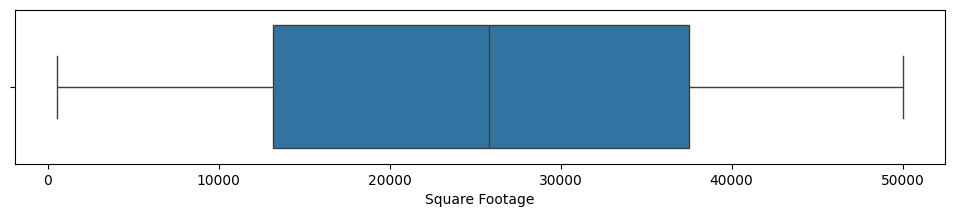

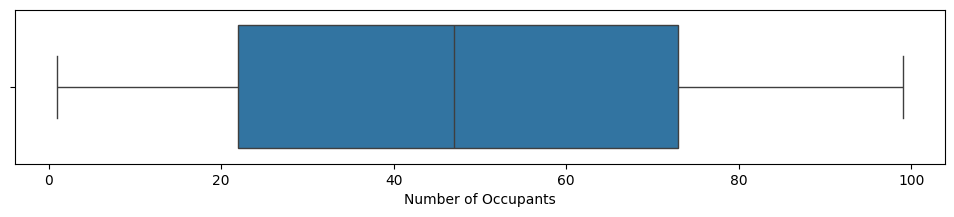

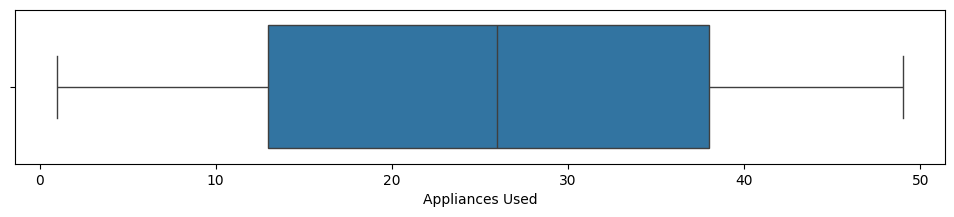

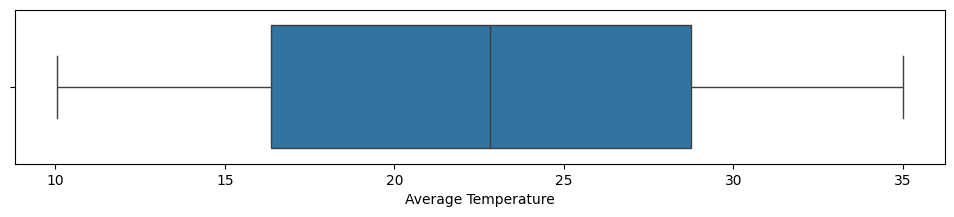

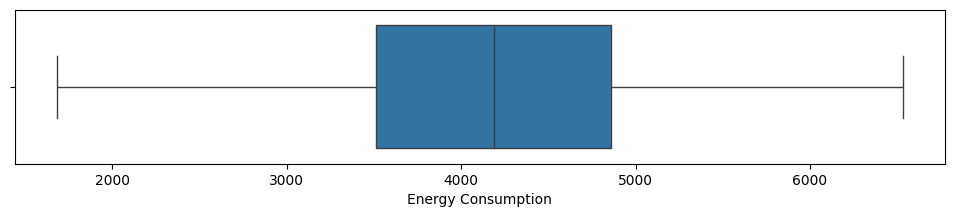

In [53]:
for x in df_check_ol:
    plt.figure(figsize=(12, 2))
    sns.boxplot(data=df_check_ol, x=x)

plt.show()

### Dist of All Object Features

In [54]:
def dist_obj_cols(feature: str):
    ax = sns.histplot(x=df[feature])

    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + (p.get_width() / 2), p.get_height()),
                    ha='center', va='bottom', fontsize=12)

    plt.title(feature)
    plt.show()

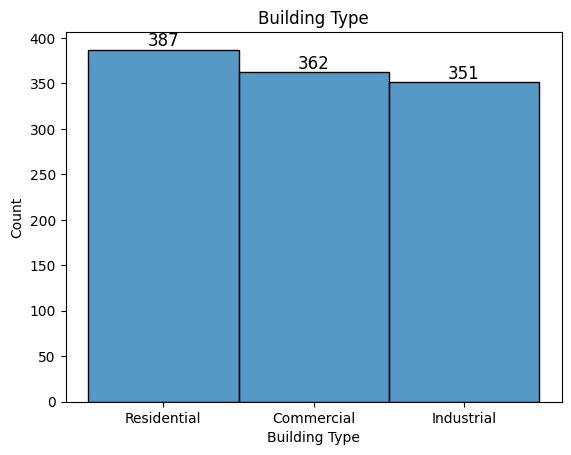

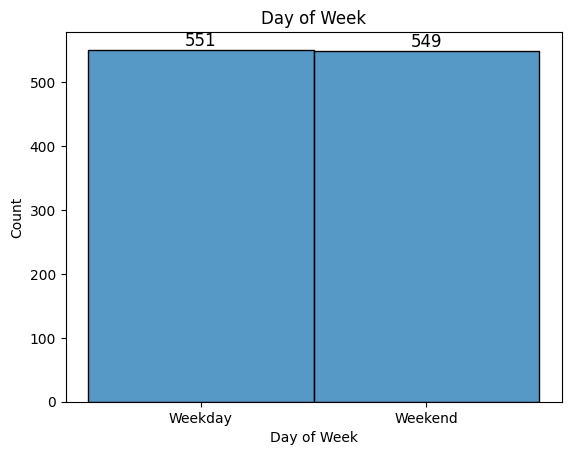

In [55]:
for x in df.columns:
    if df[x].dtype == "object":
        dist_obj_cols(x)

### Dist of All Numeric Features

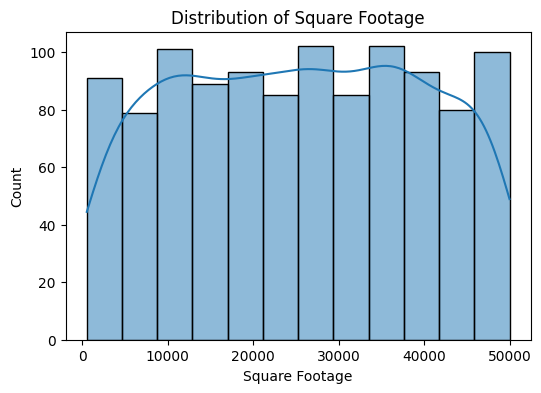

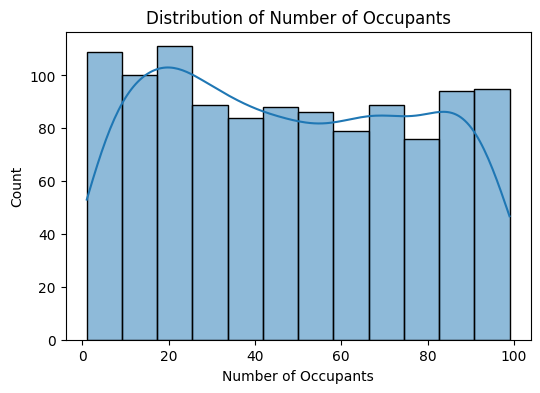

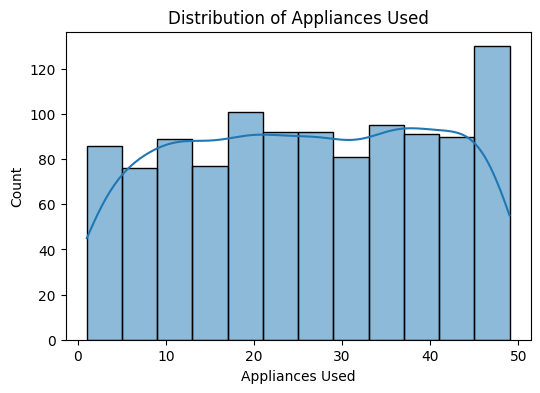

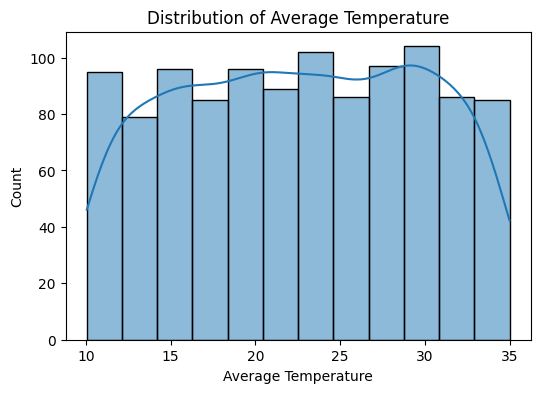

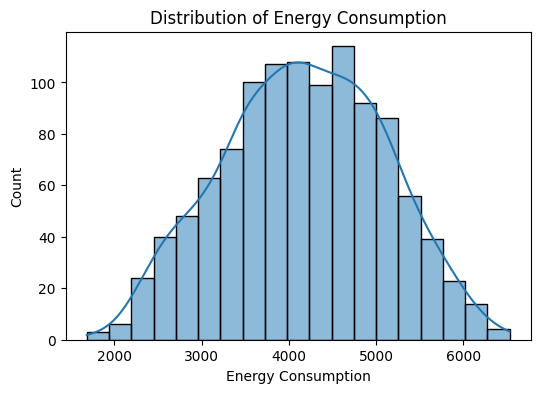

In [56]:
for x in df.select_dtypes(include=['number']).columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[x], kde=True)
    plt.title(f'Distribution of {x}')
    plt.show()

### Checking Corr

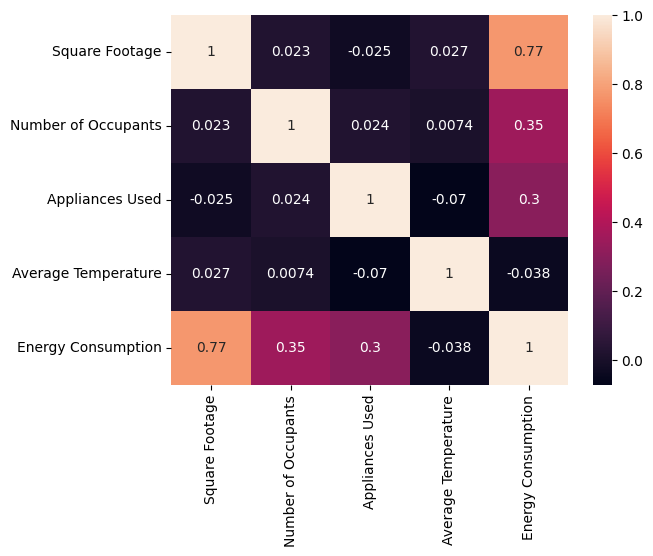

In [57]:
sns.heatmap(
    data=df.select_dtypes(exclude=["object"]).corr(),
    annot=True
);

<hr>

<h2 id='du'>Data Preparation</h2>

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Building Type        1100 non-null   object 
 1   Square Footage       1100 non-null   int64  
 2   Number of Occupants  1100 non-null   int64  
 3   Appliances Used      1100 non-null   int64  
 4   Average Temperature  1100 non-null   float64
 5   Day of Week          1100 non-null   object 
 6   Energy Consumption   1100 non-null   float64
dtypes: float64(2), int64(3), object(2)
memory usage: 60.3+ KB


### One-Hot Encoding

In [59]:
df.select_dtypes(include=["object"]).columns

Index(['Building Type', 'Day of Week'], dtype='object')

In [60]:
df_encoded = pd.get_dummies(
    data=df,
    columns=df.select_dtypes(include=["object"]).columns
)

df_encoded.tail()

Square Footage  Number of Occupants  Appliances Used  \
1095            1161                   81               11   
1096           37943                   50               23   
1097            1558                   27               29   
1098            2145                   56               12   
1099           42414                   72               24   

      Average Temperature  Energy Consumption  Building Type_Commercial  \
1095                15.45             3010.81                      True   
1096                21.73             4248.49                     False   
1097                16.86             2843.60                      True   
1098                11.77             3348.39                     False   
1099                29.62             4722.59                     False   

      Building Type_Industrial  Building Type_Residential  \
1095                     False                      False   
1096                     False                       True   
1097                     False                      False   
1098                      True                      False   
1099                     False                       True   

      Day of Week_Weekday  Day of Week_Weekend  
1095                False                 True  
1096                False                 True  
1097                False                 True  
1098                False                 True  
1099                 True                False

In [61]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Square Footage             1100 non-null   int64  
 1   Number of Occupants        1100 non-null   int64  
 2   Appliances Used            1100 non-null   int64  
 3   Average Temperature        1100 non-null   float64
 4   Energy Consumption         1100 non-null   float64
 5   Building Type_Commercial   1100 non-null   bool   
 6   Building Type_Industrial   1100 non-null   bool   
 7   Building Type_Residential  1100 non-null   bool   
 8   Day of Week_Weekday        1100 non-null   bool   
 9   Day of Week_Weekend        1100 non-null   bool   
dtypes: bool(5), float64(2), int64(3)
memory usage: 48.5 KB


### Cast all dtypes to float64

In [62]:
new_df = df_encoded.astype("float64")
new_df.tail(1)

Square Footage  Number of Occupants  Appliances Used  \
1099         42414.0                 72.0             24.0   

      Average Temperature  Energy Consumption  Building Type_Commercial  \
1099                29.62             4722.59                       0.0   

      Building Type_Industrial  Building Type_Residential  \
1099                       0.0                        1.0   

      Day of Week_Weekday  Day of Week_Weekend  
1099                  1.0                  0.0

In [63]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Square Footage             1100 non-null   float64
 1   Number of Occupants        1100 non-null   float64
 2   Appliances Used            1100 non-null   float64
 3   Average Temperature        1100 non-null   float64
 4   Energy Consumption         1100 non-null   float64
 5   Building Type_Commercial   1100 non-null   float64
 6   Building Type_Industrial   1100 non-null   float64
 7   Building Type_Residential  1100 non-null   float64
 8   Day of Week_Weekday        1100 non-null   float64
 9   Day of Week_Weekend        1100 non-null   float64
dtypes: float64(10)
memory usage: 86.1 KB


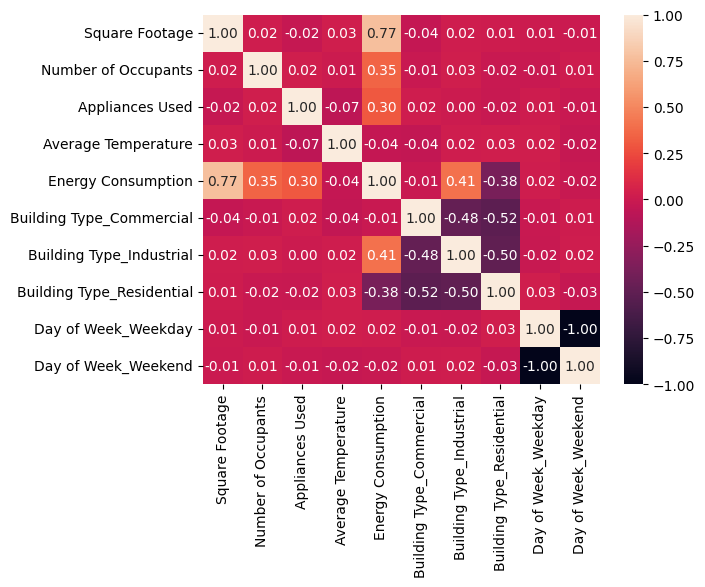

In [64]:
sns.heatmap(new_df.corr(), annot=True, fmt=".2f");

<hr>

### Data Splitting

In [65]:
X = new_df.drop(columns="Energy Consumption")
y = new_df["Energy Consumption"]

In [66]:
X

Square Footage  Number of Occupants  Appliances Used  \
0             7063.0                 76.0             10.0   
1            44372.0                 66.0             45.0   
2            19255.0                 37.0             17.0   
3            13265.0                 14.0             41.0   
4            13375.0                 26.0             18.0   
...              ...                  ...              ...   
1095          1161.0                 81.0             11.0   
1096         37943.0                 50.0             23.0   
1097          1558.0                 27.0             29.0   
1098          2145.0                 56.0             12.0   
1099         42414.0                 72.0             24.0   

      Average Temperature  Building Type_Commercial  Building Type_Industrial  \
0                   29.84                       0.0                       0.0   
1                   16.72                       1.0                       0.0   
2                   14.30                       0.0                       1.0   
3                   32.82                       0.0                       0.0   
4                   11.92                       1.0                       0.0   
...                   ...                       ...                       ...   
1095                15.45                       1.0                       0.0   
1096                21.73                       0.0                       0.0   
1097                16.86                       1.0                       0.0   
1098                11.77                       0.0                       1.0   
1099                29.62                       0.0                       0.0   

      Building Type_Residential  Day of Week_Weekday  Day of Week_Weekend  
0                           1.0                  1.0                  0.0  
1                           0.0                  1.0                  0.0  
2                           0.0                  0.0                  1.0  
3                           1.0                  1.0                  0.0  
4                           0.0                  1.0                  0.0  
...                         ...                  ...                  ...  
1095                        0.0                  0.0                  1.0  
1096                        1.0                  0.0                  1.0  
1097                        0.0                  0.0                  1.0  
1098                        0.0                  0.0                  1.0  
1099                        1.0                  1.0                  0.0  

[1100 rows x 9 columns]

In [67]:
y

0       2713.95
1       5744.99
2       4101.24
3       3009.14
4       3279.17
         ...   
1095    3010.81
1096    4248.49
1097    2843.60
1098    3348.39
1099    4722.59
Name: Energy Consumption, Length: 1100, dtype: float64

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Feature Scaling

In [69]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [70]:
X_train_scaled[:5]

array([[-0.12757915,  1.15431823,  0.26267506, -0.31288625, -0.69388867,
        -0.69928656,  1.37304257,  1.01142894, -1.01142894],
       [ 0.12342101, -0.15501326, -0.80124355, -1.57958858,  1.44115338,
        -0.69928656, -0.72830954, -0.9887002 ,  0.9887002 ],
       [-1.27321306, -0.809679  ,  1.53937738, -1.09293791,  1.44115338,
        -0.69928656, -0.72830954,  1.01142894, -1.01142894],
       [-0.43788736, -0.3962059 , -0.58845983, -1.16769874, -0.69388867,
         1.43002892, -0.72830954, -0.9887002 ,  0.9887002 ],
       [ 0.93064598,  1.49887914, -0.80124355, -0.22119844, -0.69388867,
         1.43002892, -0.72830954, -0.9887002 ,  0.9887002 ]])

In [71]:
X_test_scaled[:5]

array([[-1.28062656, -0.94750337,  0.83009831,  1.2683758 , -0.69388867,
         1.43002892, -0.72830954,  1.01142894, -1.01142894],
       [-1.29340604,  0.39628421,  0.12081924,  1.74374182,  1.44115338,
        -0.69928656, -0.72830954,  1.01142894, -1.01142894],
       [ 1.55895833, -0.49957417, -0.58845983, -0.84326495,  1.44115338,
        -0.69928656, -0.72830954,  1.01142894, -1.01142894],
       [ 0.37159697, -1.56771302, -0.73031564, -1.74321605, -0.69388867,
        -0.69928656,  1.37304257, -0.9887002 ,  0.9887002 ],
       [-0.2058093 ,  0.32737203,  1.53937738,  1.41084454, -0.69388867,
        -0.69928656,  1.37304257, -0.9887002 ,  0.9887002 ]])

### Modeling

In [72]:
ridge_cv = RidgeCV(alphas=[0.001, 0.01, 0.1, 1, 10], cv=5)
ridge_cv.fit(X_train_scaled, y_train)

print("Best alpha:", ridge_cv.alpha_)

Best alpha: 0.001


In [73]:
ridge_model = Ridge(alpha=ridge_cv.alpha_)
ridge_model.fit(X_train_scaled, y_train)

Ridge(alpha=np.float64(0.001))

In [74]:
y_pred = ridge_model.predict(X_test_scaled)

In [75]:
res = pd.DataFrame({"Actual": y_test, "Pred": y_pred})
res.sample(10)

Actual         Pred
107   4172.08  4172.098807
67    4722.68  4722.698260
885   3542.19  3542.202193
578   5744.86  5744.848740
723   4642.27  4642.249698
1099  4722.59  4722.599726
821   4217.88  4217.900841
158   3028.56  3028.550293
247   5369.95  5369.948882
874   5646.19  5646.199677

<h2 id='ml'>Evaluation</h2>

<hr>

In [76]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("MAE:", mae)
print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")

MAE: 0.012032354589591291
Mean Squared Error: 0.0002
R² Score: 1.0000


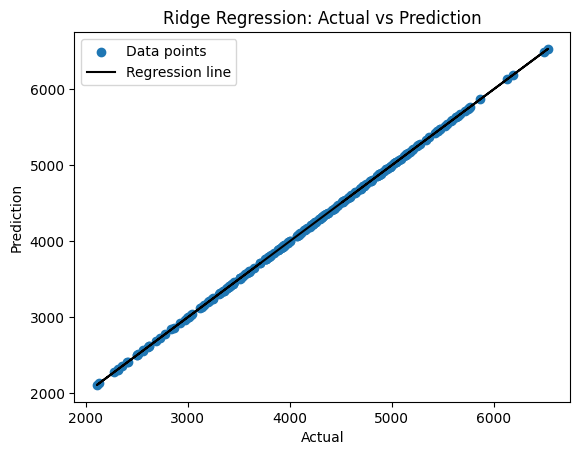

In [77]:
plt.scatter(y_test, y_pred, label='Data points')
m, b = np.polyfit(y_test, y_pred, 1)
plt.plot(y_test, m * y_test + b, color='black', label='Regression line')

plt.xlabel("Actual")
plt.ylabel("Prediction")
plt.title("Ridge Regression: Actual vs Prediction")
plt.legend()
plt.show()

<h2 id='ml'>Deployment</h2>

In [78]:
joblib.dump(ridge_model, '../models/model_ridge.joblib')

['../models/model_ridge.joblib']



---


Copyright © 2025 by DGX Development Team, Gunadarma University


https://www.hpc-hub.gunadarma.ac.id/